In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from src.model import *
from src.mtg_df_prep import *


In [2]:
parent_dir = '/home/jovyan/data/art/'
target_size = (224, 224)
batch_size = 8


In [3]:
cards = load_color_data(mono=True)

In [4]:
cards.set_type.unique()

array(['expansion', 'promo', 'core', 'draft_innovation', 'commander',
       'starter', 'duel_deck', 'funny', 'token', 'masterpiece',
       'planechase', 'masters', 'spellbook', 'box', 'vanguard',
       'archenemy', 'from_the_vault', 'memorabilia', 'treasure_chest',
       'premium_deck'], dtype=object)

In [5]:
df = cards[cards.set_type.isin(['core'])]
# df = cards[cards.set.isin(['m10'])]
df.set.unique()

array(['m21', 'm19', '7ed', 'm13', 'ori', '10e', '5ed', 'm12', 'm20',
       'm15', 'm11', '9ed', '8ed', 'leb', 'm10', 'lea', 'm14', '4ed',
       '6ed', 'sum', '3ed'], dtype=object)

In [6]:
train_df, test_df = prepare_data(df, test_size=0.2)

train_gen, valid_gen, test_gen = flow_to_generators(
    train_df, test_df,
    parent_dir=parent_dir,
    target_size=target_size,
    batch_size=batch_size
)

Found 1532 validated image filenames belonging to 6 classes.
Found 383 validated image filenames belonging to 6 classes.
Found 482 validated image filenames.


/opt/conda/lib/python3.8/site-packages/keras_preprocessing/image/dataframe_iterator.py:279: UserWarning: Found 13 invalid image filename(s) in x_col="path". These filename(s) will be ignored.
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/keras_preprocessing/image/dataframe_iterator.py:279: UserWarning: Found 13 invalid image filename(s) in x_col="path". These filename(s) will be ignored.
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/keras_preprocessing/image/dataframe_iterator.py:279: UserWarning: Found 1 invalid image filename(s) in x_col="path". These filename(s) will be ignored.
  warnings.warn(


In [7]:
input_shape = target_size + (3,)
model = Sequential()

model.add(Conv2D(32, (3,3), padding='same', activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(128, (3,3), activation='relu'))
model.add(Dropout(0.2))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(6, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(0.01)))

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [8]:
model.layers

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 110, 110, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 55, 55, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 53, 53, 128)       73856     
_________________________________________________________________
dropout (Dropout)            (None, 53, 53, 128)       0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 26, 26, 128)       0

In [10]:
history = model.fit(
    train_gen,
    validation_data=train_gen,
    steps_per_epoch=train_gen.n//train_gen.batch_size,
    validation_steps=valid_gen.n//valid_gen.batch_size,
    epochs=20
)

Epoch 1/20
191/191 [==============================] - 54s 278ms/step - loss: 2.1946 - accuracy: 0.2319 - val_loss: 1.6609 - val_accuracy: 0.3191
Epoch 2/20
191/191 [==============================] - 53s 276ms/step - loss: 1.6622 - accuracy: 0.3504 - val_loss: 1.5873 - val_accuracy: 0.4096
Epoch 3/20
191/191 [==============================] - 53s 278ms/step - loss: 1.6577 - accuracy: 0.3522 - val_loss: 1.5250 - val_accuracy: 0.4202
Epoch 4/20
191/191 [==============================] - 53s 277ms/step - loss: 1.6119 - accuracy: 0.3657 - val_loss: 1.6048 - val_accuracy: 0.3856
Epoch 5/20
191/191 [==============================] - 53s 278ms/step - loss: 1.6033 - accuracy: 0.3672 - val_loss: 1.5345 - val_accuracy: 0.4415
Epoch 6/20
191/191 [==============================] - 53s 277ms/step - loss: 1.6127 - accuracy: 0.3981 - val_loss: 1.4812 - val_accuracy: 0.4362
Epoch 7/20
191/191 [==============================] - 52s 274ms/step - loss: 1.5139 - accuracy: 0.4501 - val_loss: 1.6096 - val_ac

In [11]:
score = model.evaluate(valid_gen)
print('Test loss:', score[0])
print('Test accuracy:', score[1])


48/48 [==============================] - 6s 125ms/step - loss: 1.6259 - accuracy: 0.4073
Test loss: 1.625884771347046
Test accuracy: 0.40731069445610046


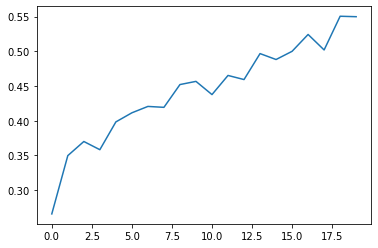

In [12]:
fig, ax = plt.subplots()
ax.plot(history.epoch, history.history['accuracy'])
plt.show()

In [13]:
test_df[test_df['path'].isin(test_gen.filenames)]['target']

8863     W
27699    W
21940    G
15938    B
5349     B
        ..
5282     G
25943    R
175      C
11026    W
4747     B
Name: target, Length: 482, dtype: object

In [14]:
filenames = test_gen.filenames
predict = model.predict(test_gen, steps=len(filenames))
pred = ['CWUBRG'[c] for c in predict.argmax(axis=1)]
true = test_df[test_df['path'].isin(test_gen.filenames)]['target']

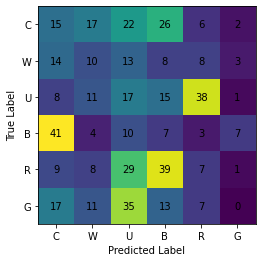

In [15]:
plot_conf_matrix(true, pred)

In [16]:
pd.DataFrame(history.history)

,loss,accuracy,val_loss,val_accuracy
0,1.854367,0.265748,1.660873,0.319149
1,1.679129,0.349738,1.587264,0.409574
2,1.632169,0.370079,1.524997,0.420213
3,1.613519,0.358268,1.604833,0.385638
4,1.566680,0.398294,1.534457,0.441489
5,1.574608,0.411417,1.481214,0.436170
6,1.538880,0.420604,1.609575,0.364362
7,1.528169,0.419291,1.433472,0.484043
8,1.473521,0.452100,1.518231,0.425532
9,1.463725,0.456693,1.430208,0.502660
